In [1]:
import pandas as pd

# Verileri yükleyelim
train = pd.read_csv("data.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Boyutlara bakalım
print("Train shape:", train.shape)
print("Submission shape:", sample_submission.shape)

# İlk 5 satırı görüntüleyelim
train.head()


Train shape: (31644, 10)
Submission shape: (10415, 2)


,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


Eksik Veri Kontrolü

In [2]:
# Genel bilgi
train.info()

# Eksik değer sayıları
missing = train.isnull().sum()
print("Eksik değerler:\n", missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB
Eksik değerler:
 id                         0
author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm] 

Hedef Değişkenin Dağılımı (chf_exp [MW/m2])

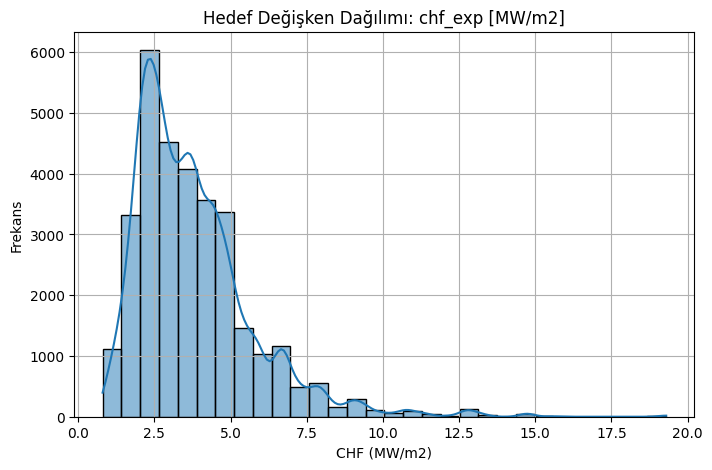

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hedef değişkenin histogramı
plt.figure(figsize=(8, 5))
sns.histplot(train["chf_exp [MW/m2]"], kde=True, bins=30)
plt.title("Hedef Değişken Dağılımı: chf_exp [MW/m2]")
plt.xlabel("CHF (MW/m2)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()


Eksik Veri Görselleştirme (Isı Haritası)

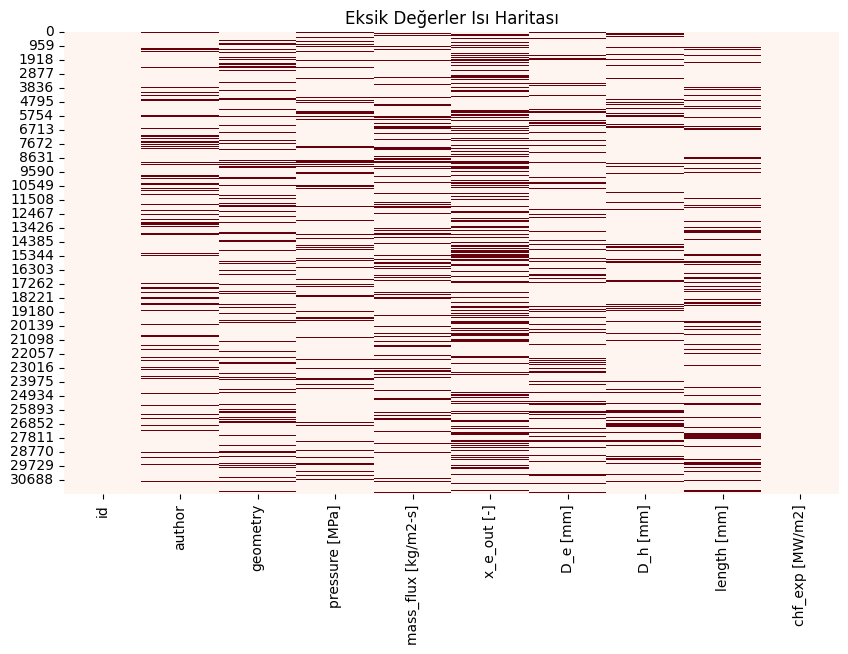

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap="Reds")
plt.title("Eksik Değerler Isı Haritası")
plt.show()


Korelasyon Matrisi (Sayısal Sütunlar)

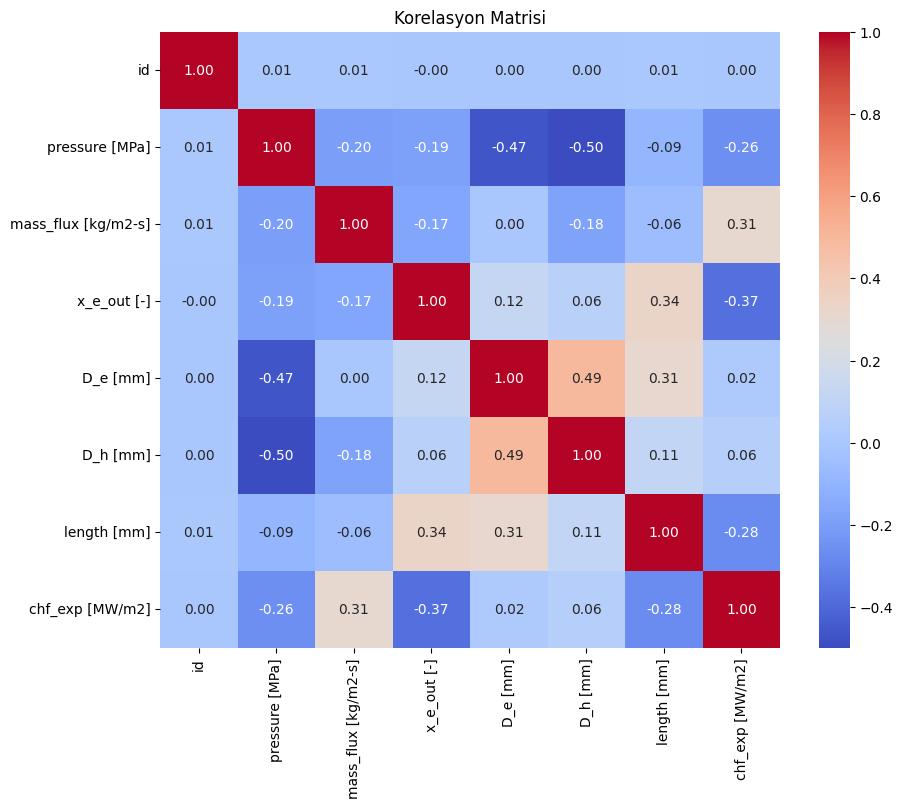

In [5]:
# Sayısal kolonları al
num_cols = train.select_dtypes(include="number")

# Korelasyon matrisi
plt.figure(figsize=(10, 8))
sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

In [6]:
# ID sütununu silelim
train = train.drop("id", axis=1)

# Kategorik sütunları mode (en sık değer) ile doldur
train["author"] = train["author"].fillna(train["author"].mode()[0])
train["geometry"] = train["geometry"].fillna(train["geometry"].mode()[0])

# Sayısal sütunları mean ile doldur
num_cols = train.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].mean())

# Son kontrol
print("Kalan eksik değer sayısı:\n", train.isnull().sum().sum())


Kalan eksik değer sayısı:
 0


Model Eğitimi (RandomForestRegressor)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Özellik ve hedefi ayır
X = train.drop("chf_exp [MW/m2]", axis=1)
y = train["chf_exp [MW/m2]"]

# Kategorik değişkenleri one-hot encode et
X = pd.get_dummies(X)

# Eğitim-test ayrımı (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli tanımla ve eğit
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Değerlendirme
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse, 4))
print("R² Score:", round(r2, 4))


RMSE: 1.7304
R² Score: 0.2766


Model Performansı:
RMSE: 1.7304

R² Score: 0.2766 → Bu değer düşük. Model hedefi yeterince iyi açıklayamıyor.

Ne Anlama Geliyor?
Model bazı ilişkileri öğrenmiş ama genelleme kapasitesi zayıf.

Sebebi:

Eksik değerlerin ortalama ile doldurulması (daha sofistike imputation gerekebilir),

Belki de mass_flux, pressure, x_e_out gibi bazı özelliklerin etkileşimleri dikkate alınmadı,

Ya da model karmaşık ilişkileri yakalayamıyor.


Test Verisi Üzerinde Tahmin

In [9]:
# Test verisini yükle
test = pd.read_csv("sample_submission.csv")  # id sütunları var
X_test_raw = pd.read_csv("data.csv")

# Sadece test verisini alalım (örneğin: test.csv varsa onu kullan)
X_test_raw = X_test_raw.iloc[:test.shape[0]].copy()

# id'yi al (submission için)
test_ids = X_test_raw["id"]

# id sütununu kaldır
X_test_raw = X_test_raw.drop("id", axis=1)

# Eksik verileri aynı şekilde doldur
X_test_raw["author"] = X_test_raw["author"].fillna(train["author"].mode()[0])
X_test_raw["geometry"] = X_test_raw["geometry"].fillna(train["geometry"].mode()[0])

for col in X_test_raw.select_dtypes(include=["float64", "int64"]).columns:
    if X_test_raw[col].isnull().sum() > 0:
        X_test_raw[col] = X_test_raw[col].fillna(train[col].mean())

# One-hot encoding
X_test_ready = pd.get_dummies(X_test_raw)

# Eğitimde olmayan sütunlar varsa onları da ekleyelim
for col in X.columns:
    if col not in X_test_ready.columns:
        X_test_ready[col] = 0

# Aynı sıralamaya al
X_test_ready = X_test_ready[X.columns]

# Tahmin
test_preds = model.predict(X_test_ready)

# Submission dosyası oluştur
submission = pd.DataFrame({
    "id": test_ids,
    "chf_exp [MW/m2]": test_preds
})

# Kaydet
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv dosyası oluşturuldu.")


✅ submission.csv dosyası oluşturuldu.


In [10]:
import joblib
joblib.dump(model, "rf_model.pkl")


['rf_model.pkl']

In [11]:
joblib.dump(list(X.columns), "model_columns.pkl")


['model_columns.pkl']